In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

file_path = "F:\\All data\\Patient_Signal\\PPG.csv"
data = pd.read_csv(file_path, header=None)

data.columns = ['Name', 'i', 'Bad', 'hands', 'label', 'systolic peak', 'Diastolic peak', 'Cardiac cycle', 'Cycle Area', 'SSI', 'Peak to Valley', 'Systolic peak y', 'Delta_T', '1st Derivative cycle', '1st Derivative peak', 'Ratio_BA', 'Ratio_CA', 'Ratio_DA', 'Ratio_BDCE_A', 'Ratio_CDB_A']
# Display the first few rows of the dataframe to understand its structure
data.head()

,Name,i,Bad,hands,label,systolic peak,Diastolic peak,Cardiac cycle,Cycle Area,SSI,Peak to Valley,Systolic peak y,Delta_T,1st Derivative cycle,1st Derivative peak,Ratio_BA,Ratio_CA,Ratio_DA,Ratio_BDCE_A,Ratio_CDB_A
0,伍黃秀霞,1,Right,Left,1,1278.0,0.390019,993.0,315.004855,987.0,720.0,0.516570,-1277.609981,1000.0,0.447513,1.022991,1.029483,1.047664,-2.109080,1.022221
1,伍黃秀霞,1,Right,Right,1,1265.0,0.275706,977.0,267.261331,995.0,714.0,0.485722,-1264.724294,994.0,0.327676,0.999176,0.997674,0.993834,-1.982910,1.000930
2,伍黃秀霞,3,Right,Left,1,1280.0,0.344179,997.0,307.701319,1011.0,718.0,0.468073,-1279.655821,994.0,0.427002,1.027341,1.050224,1.074771,-2.195227,1.027423
3,伍黃秀霞,3,Right,Right,1,1278.0,0.350065,979.0,286.925793,1011.0,705.0,0.506998,-1277.649935,1005.0,0.343972,0.991613,0.974413,0.961078,-1.887815,0.991555
4,伍黃秀霞,5,Right,Left,1,1296.0,0.354134,1000.0,318.004937,1009.0,701.0,0.428415,-1295.645866,996.0,0.360314,1.029600,1.045462,1.071122,-2.174579,1.028988


In [79]:
info_columns = data[['Name', 'i', 'Bad', 'hands']]
X = data.iloc[:, 5:]  # 特徵列
y = data['label']     # 標籤
#印出x的標題
print(X.columns)

# 分割訓練和測試集
X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(X, y, info_columns, test_size=0.3, random_state=42)

# 特徵標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Index(['systolic peak', 'Diastolic peak', 'Cardiac cycle', 'Cycle Area', 'SSI',
       'Peak to Valley', 'Systolic peak y', 'Delta_T', '1st Derivative cycle',
       '1st Derivative peak', 'Ratio_BA', 'Ratio_CA', 'Ratio_DA',
       'Ratio_BDCE_A', 'Ratio_CDB_A'],
      dtype='object')


In [80]:
# 繪製混淆矩陣
def plot_confusion_matrix(conf_matrix, title='Confusion Matrix'):
    plt.figure(figsize=(5, 5), dpi=120)
    plt.imshow(conf_matrix, cmap='summer')
    plt.colorbar()

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, str(conf_matrix[i, j]), fontsize=12,
                     horizontalalignment='center', verticalalignment='center')

    plt.xticks(np.arange(0, 2), ['Predicted 0', 'Predicted 1'])
    plt.yticks(np.arange(0, 2), ['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

In [81]:
# 計算性能指標
def calculate_metrics(conf_matrix):
    tp = conf_matrix[0, 0]
    fn = conf_matrix[0, 1]
    fp = conf_matrix[1, 0]
    tn = conf_matrix[1, 1]
    accuracy = (tp + tn) / (tp + fn + fp + tn) if (tp + fn + fp + tn) != 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) != 0 else 0

    metrics = {
        "Accuracy": round(accuracy,3),
        "Sensitivity (Recall)": round(sensitivity,3),
        "Specificity": round(specificity,3),
        "Precision": round(precision,3),
        "F1-Score": round(f1_score,3)
    }
    return metrics

In [82]:
# 儲存結果到 CSV
def save_results_to_csv(filename, info, y_test, y_pred, Last_metrics):
    new_data = pd.DataFrame({
        'Name': info['Name'].values,
        'Cycle': info['i'].values,
        'Hands': info['hands'].values,
        'Actual_Label': y_test.values,
        'Predicted_Label': y_pred
    })

    new_data = new_data.sort_values(by='Name')
    new_data['Is_Correct'] = new_data['Actual_Label'] == new_data['Predicted_Label']

    # 將最終的 Actual_Label 和 Predicted_Label 的總結結果保存
    final_summary = new_data.groupby('Name').agg(
    Actual_0_Count=('Actual_Label', lambda x: (x == 0).sum()),
    Actual_1_Count=('Actual_Label', lambda x: (x == 1).sum()),
    Predicted_0_Count=('Predicted_Label', lambda x: (x == 0).sum()),
    Predicted_1_Count=('Predicted_Label', lambda x: (x == 1).sum())
    ).reset_index()

    # 判斷總體的預測結果
    final_summary['Predicted_Label'] = final_summary.apply(lambda row: 0 if row['Predicted_0_Count'] > row['Predicted_1_Count'] else 1, axis=1)
    final_summary['Actual_Label'] = final_summary.apply(lambda row: 0 if row['Actual_0_Count'] > row['Actual_1_Count'] else 1, axis=1)


    conf_matrix = confusion_matrix(final_summary['Actual_Label'], final_summary['Predicted_Label'])
    plot_confusion_matrix(conf_matrix, title='Final Confusion Matrix')
    Final_metrics = calculate_metrics(conf_matrix)
    print("Final Metrics:", Final_metrics)

    if Final_metrics['Accuracy'] > Last_metrics['Accuracy']:
        # 保存總結至 CSV
        new_data.to_csv(f"F:\\All data\\Patient_Signal\\Exhaustive Search\\{filename}.csv", index=False, encoding='utf-8-sig')
        print(f"Results saved to {filename}.csv")
        final_summary.to_csv(f"F:\\All data\\Patient_Signal\\Exhaustive Search\\{filename}_Final.csv", index=False, encoding='utf-8-sig')
        print(f"Results saved to {filename}_Final.csv")
    else:
        print("Accuracy is not improved. Results not saved.")
        Final_metrics = {'Accuracy': 0, 'Sensitivity': 0, 'Specificity': 0, 'Precision': 0, 'F1-Score': 0}

    return Final_metrics
    

    

In [83]:
# 生成所有可能的特徵子集
def generate_feature_subsets(features):
    subsets = []
    for r in range(1, len(features) + 1):
        subsets.extend(combinations(features, r))
    return subsets

# 評估特徵子集
def evaluate_feature_subsets(X, y, feature_subsets, model_train_function, info_train, info_test):
    best_subset = None
    best_metrics = None
    best_conf_matrix = None
    best_y_pred = None
    best_model = None

    results = []

    for subset in feature_subsets:
        subset_columns = list(subset)
        print(f"Evaluating subset: {subset_columns}")
        X_train_subset = X_train[:, [X.columns.get_loc(col) for col in subset_columns]]
        X_test_subset = X_test[:, [X.columns.get_loc(col) for col in subset_columns]]

        # 使用指定模型訓練函式進行訓練與測試
        model, metrics, conf_matrix, y_pred, *_ = model_train_function(
            X_train_subset, y_train, X_test_subset, y_test, subset_columns
        )

        # 記錄結果
        results.append((subset_columns, metrics))

        # 更新最佳子集
        if not best_metrics or metrics['F1-Score'] > best_metrics['F1-Score']:
            best_subset = subset_columns
            best_metrics = metrics
            best_conf_matrix = conf_matrix
            best_y_pred = y_pred
            best_model = model

    # 保存所有結果
    result_df = pd.DataFrame(results, columns=['Feature Subset', 'Metrics'])
    result_df.to_csv("F:\\All data\\Patient_Signal\\Classfication\\Feature_Subset_Evaluation.csv", index=False)

    return best_subset, best_metrics, best_conf_matrix, best_y_pred, best_model

feature_subsets = generate_feature_subsets(X.columns)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
最佳參數: {'C': 100, 'class_weight': 'balanced', 'kernel': 'rbf'}
特徵重要性排序：
                  Feature  Importance
1         Diastolic peak    0.116490
10              Ratio_BA    0.111816
14           Ratio_CDB_A    0.095167
5         Peak to Valley    0.087042
11              Ratio_CA    0.074960
13          Ratio_BDCE_A    0.074827
9    1st Derivative peak    0.063595
12              Ratio_DA    0.062427
3             Cycle Area    0.057939
0          systolic peak    0.050451
7                Delta_T    0.050372
4                    SSI    0.034254
8   1st Derivative cycle    0.026314
2          Cardiac cycle    0.025571
6        Systolic peak y    0.016251


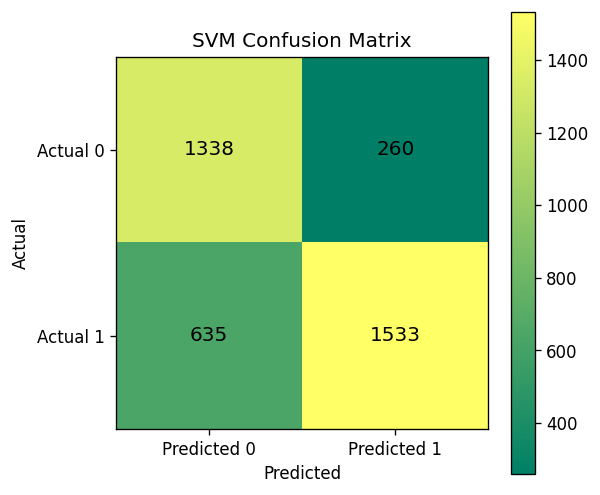

SVM Metrics: {'Accuracy': 0.762, 'Sensitivity (Recall)': 0.837, 'Specificity': 0.707, 'Precision': 0.678, 'F1-Score': 0.749}


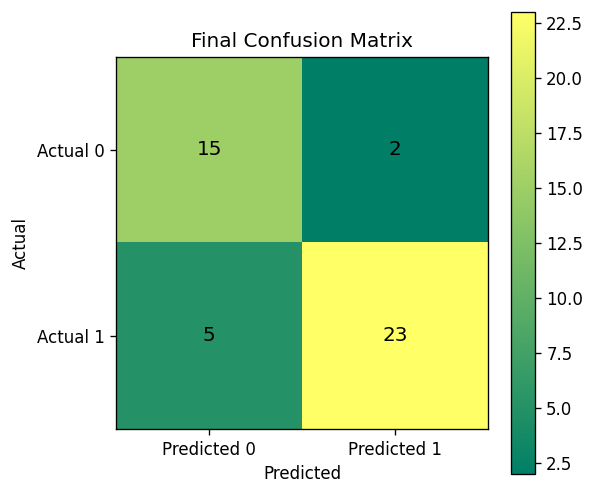

Final Metrics: {'Accuracy': 0.844, 'Sensitivity (Recall)': 0.882, 'Specificity': 0.821, 'Precision': 0.75, 'F1-Score': 0.811}
Results saved to SVM_Results.csv
Results saved to SVM_Results_Final.csv


In [84]:
def train_svm(X_train, y_train, X_test, y_test, X_columns):
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'class_weight': ['balanced']
    }

    svm_grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    svm_grid_search.fit(X_train, y_train)

    best_model = svm_grid_search.best_estimator_
    best_params = svm_grid_search.best_params_
    y_pred = best_model.predict(X_test)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    metrics = calculate_metrics(conf_matrix)

    # 如果使用線性核，可以直接通過 coef_ 計算特徵重要性
    if best_params['kernel'] == 'linear':
        feature_importance = np.abs(best_model.coef_[0])
        feature_importance_df = pd.DataFrame({
            'Feature': X_columns,
            'Importance': feature_importance
        }).sort_values(by='Importance', ascending=False)
    else:
        # 如果使用非線性核，則使用置換特徵重要性來估算
        results = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
        feature_importance = results.importances_mean  # 平均置換重要性得分
        feature_importance_df = pd.DataFrame({
            'Feature': X_columns,
            'Importance': feature_importance
        }).sort_values(by='Importance', ascending=False)

    # 預測測試集
    print("最佳參數:", best_params)
    print("特徵重要性排序：\n", feature_importance_df)

    return best_model, metrics, conf_matrix, y_pred, feature_importance_df


# SVM
Last_metrics = {'Accuracy': 0, 'Sensitivity': 0, 'Specificity': 0, 'Precision': 0, 'F1-Score': 0}
svm_model, svm_metrics, svm_conf_matrix, svm_y_pred, feature_importance_df = train_svm(X_train, y_train, X_test, y_test, X.columns)
plot_confusion_matrix(svm_conf_matrix, title='SVM Confusion Matrix')
print("SVM Metrics:", svm_metrics)
Last_metrics = save_results_to_csv('SVM_Results', info_test, y_test, svm_y_pred, Last_metrics)

In [85]:
Modify_SVM_X = X
Modify_SVM_X_train = X_train
Modify_SVM_X_test = X_test
Modify_SVM_y_train = y_train
Modify_SVM_y_test = y_test

['Diastolic peak' 'Ratio_BA' 'Ratio_CDB_A' 'Peak to Valley' 'Ratio_CA'
 'Ratio_BDCE_A' '1st Derivative peak' 'Ratio_DA' 'Cycle Area'
 'systolic peak' 'Delta_T' 'SSI' '1st Derivative cycle' 'Cardiac cycle'
 'Systolic peak y']
Systolic peak y
Fitting 5 folds for each of 16 candidates, totalling 80 fits
最佳參數: {'C': 100, 'class_weight': 'balanced', 'kernel': 'rbf'}
特徵重要性排序：
                  Feature  Importance
1         Diastolic peak    0.122809
9               Ratio_BA    0.116118
5         Peak to Valley    0.105284
13           Ratio_CDB_A    0.099655
10              Ratio_CA    0.098513
12          Ratio_BDCE_A    0.075863
11              Ratio_DA    0.070526
8    1st Derivative peak    0.062321
6                Delta_T    0.060329
0          systolic peak    0.060303
3             Cycle Area    0.056267
4                    SSI    0.034121
2          Cardiac cycle    0.030058
7   1st Derivative cycle    0.027695


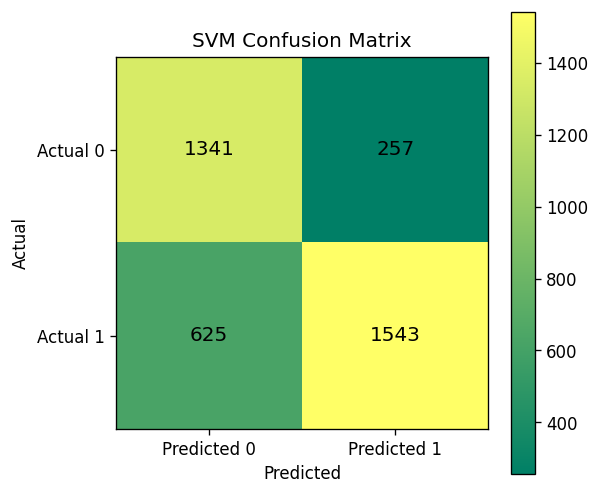

SVM Metrics: {'Accuracy': 0.766, 'Sensitivity (Recall)': 0.839, 'Specificity': 0.712, 'Precision': 0.682, 'F1-Score': 0.753}


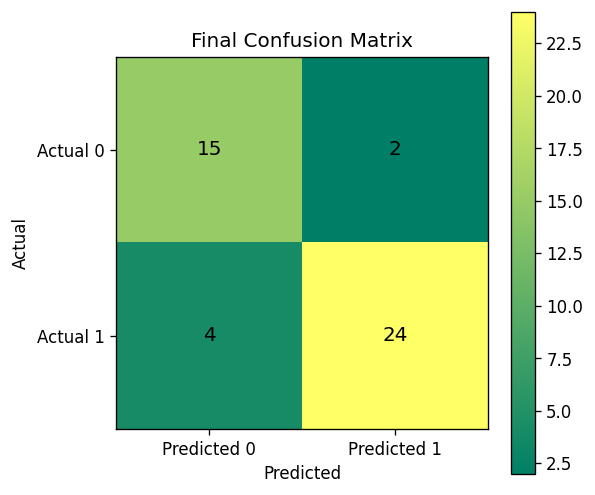

Final Metrics: {'Accuracy': 0.867, 'Sensitivity (Recall)': 0.882, 'Specificity': 0.857, 'Precision': 0.789, 'F1-Score': 0.833}
Results saved to SVM_Results.csv
Results saved to SVM_Results_Final.csv
['Diastolic peak' 'Ratio_BA' 'Peak to Valley' 'Ratio_CDB_A' 'Ratio_CA'
 'Ratio_BDCE_A' 'Ratio_DA' '1st Derivative peak' 'Delta_T' 'systolic peak'
 'Cycle Area' 'SSI' 'Cardiac cycle' '1st Derivative cycle']
1st Derivative cycle
Fitting 5 folds for each of 16 candidates, totalling 80 fits
最佳參數: {'C': 100, 'class_weight': 'balanced', 'kernel': 'rbf'}
特徵重要性排序：
                 Feature  Importance
1        Diastolic peak    0.124456
8              Ratio_BA    0.112108
12          Ratio_CDB_A    0.104169
9              Ratio_CA    0.101992
5        Peak to Valley    0.099336
11         Ratio_BDCE_A    0.076527
10             Ratio_DA    0.075252
7   1st Derivative peak    0.066224
0         systolic peak    0.064445
6               Delta_T    0.064286
3            Cycle Area    0.061816
4        

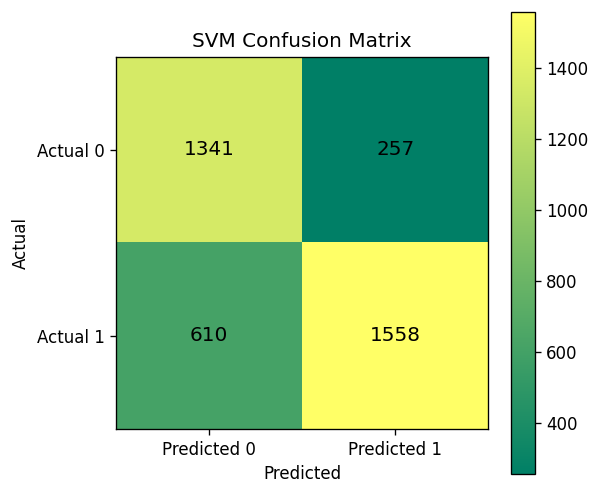

SVM Metrics: {'Accuracy': 0.77, 'Sensitivity (Recall)': 0.839, 'Specificity': 0.719, 'Precision': 0.687, 'F1-Score': 0.756}


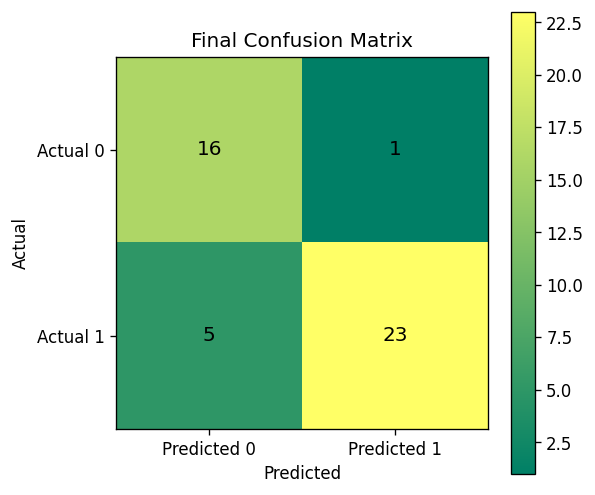

Final Metrics: {'Accuracy': 0.867, 'Sensitivity (Recall)': 0.941, 'Specificity': 0.821, 'Precision': 0.762, 'F1-Score': 0.842}
Accuracy is not improved. Results not saved.


In [86]:
while Last_metrics != {'Accuracy': 0, 'Sensitivity': 0, 'Specificity': 0, 'Precision': 0, 'F1-Score': 0}:
    print(feature_importance_df['Feature'].values)
    print(feature_importance_df['Feature'].values[-1])

    # 獲取要刪除的特徵
    Delete_Feature = feature_importance_df['Feature'].values[-1]
    Delete_Index = Modify_SVM_X.columns.get_loc(Delete_Feature)

    # 刪除特徵列
    Modify_SVM_X_train = np.delete(Modify_SVM_X_train, Delete_Index, axis=1)
    Modify_SVM_X_test = np.delete(Modify_SVM_X_test, Delete_Index, axis=1)

    # 更新 Modify_X，刪除對應的特徵列
    Modify_SVM_X = Modify_SVM_X.drop(Delete_Feature, axis=1)

    # 確保刪除後的特徵對應於最新的 Modify_X.columns
    svm_model, svm_metrics, svm_conf_matrix, svm_y_pred, feature_importance_df = train_svm(Modify_SVM_X_train, y_train, Modify_SVM_X_test, y_test, Modify_SVM_X.columns)

    # 顯示混淆矩陣
    plot_confusion_matrix(svm_conf_matrix, title='SVM Confusion Matrix')

    # 顯示 SVM 評估指標
    print("SVM Metrics:", svm_metrics)

    # 儲存結果並更新 Last_metrics
    Last_metrics = save_results_to_csv('SVM_Results', info_test, y_test, svm_y_pred, Last_metrics)


In [87]:
info_columns = data[['Name', 'i', 'Bad', 'hands']]
X = data.iloc[:, 5:]  # 特徵列
y = data['label']     # 標籤
#印出x的標題
print(X.columns)

# 分割訓練和測試集
X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(X, y, info_columns, test_size=0.3, random_state=42)

# 特徵標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Index(['systolic peak', 'Diastolic peak', 'Cardiac cycle', 'Cycle Area', 'SSI',
       'Peak to Valley', 'Systolic peak y', 'Delta_T', '1st Derivative cycle',
       '1st Derivative peak', 'Ratio_BA', 'Ratio_CA', 'Ratio_DA',
       'Ratio_BDCE_A', 'Ratio_CDB_A'],
      dtype='object')


Fitting 5 folds for each of 20 candidates, totalling 100 fits
最佳參數: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
特徵重要性排序：
                  Feature  Importance
1         Diastolic peak    0.092937
9    1st Derivative peak    0.032315
3             Cycle Area    0.019118
4                    SSI    0.015905
8   1st Derivative cycle    0.013250
14           Ratio_CDB_A    0.008603
0          systolic peak    0.007435
10              Ratio_BA    0.007302
7                Delta_T    0.007037
6        Systolic peak y    0.005364
5         Peak to Valley    0.004594
13          Ratio_BDCE_A    0.002124
12              Ratio_DA    0.000956
11              Ratio_CA    0.000558
2          Cardiac cycle   -0.001009


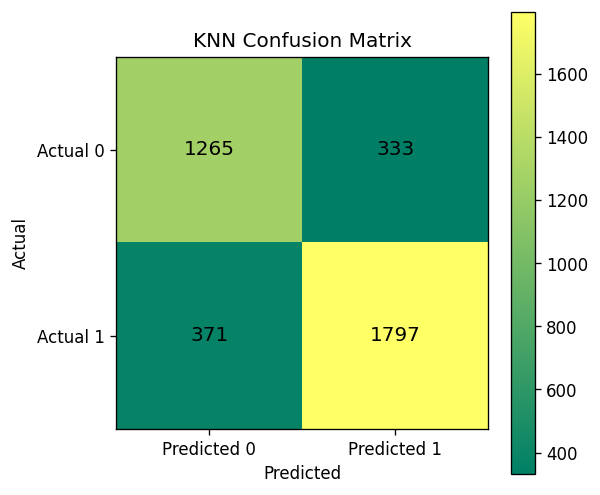

KNN Metrics: {'Accuracy': 0.813, 'Sensitivity (Recall)': 0.792, 'Specificity': 0.829, 'Precision': 0.773, 'F1-Score': 0.782}


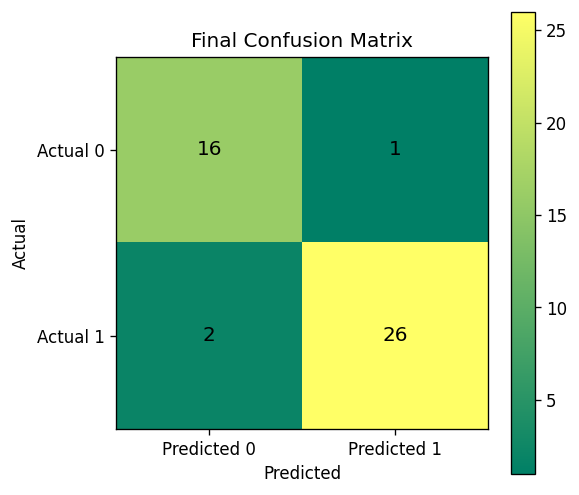

Final Metrics: {'Accuracy': 0.933, 'Sensitivity (Recall)': 0.941, 'Specificity': 0.929, 'Precision': 0.889, 'F1-Score': 0.914}
Results saved to KNN_Results.csv
Results saved to KNN_Results_Final.csv


In [88]:
def train_knn(X_train, y_train, X_test, y_test, X_columns):
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    knn_grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    knn_grid_search.fit(X_train, y_train)

    best_model = knn_grid_search.best_estimator_
    best_params = knn_grid_search.best_params_
    y_pred = best_model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    metrics = calculate_metrics(conf_matrix)

    # 特徵重要性 - 基於置換的重要性
    results = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    feature_importance = results.importances_mean  # 平均置換重要性得分
    feature_importance_df = pd.DataFrame({
        'Feature': X_columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    print("最佳參數:", best_params)
    print("特徵重要性排序：\n", feature_importance_df)

    return best_model, metrics, conf_matrix, y_pred, feature_importance_df

# KNN
Last_metrics = {'Accuracy': 0, 'Sensitivity': 0, 'Specificity': 0, 'Precision': 0, 'F1-Score': 0}
knn_model, knn_metrics, knn_conf_matrix, knn_y_pred, feature_importance_df = train_knn(X_train, y_train, X_test, y_test, X.columns)
plot_confusion_matrix(knn_conf_matrix, title='KNN Confusion Matrix')
print("KNN Metrics:", knn_metrics)
Last_metrics = save_results_to_csv('KNN_Results', info_test, y_test, knn_y_pred, Last_metrics)


In [89]:
Modify_KNN_X = X
Modify_KNN_X_train = X_train
Modify_KNN_X_test = X_test
Modify_KNN_y_train = y_train
Modify_KNN_y_test = y_test

['Diastolic peak' '1st Derivative peak' 'Cycle Area' 'SSI'
 '1st Derivative cycle' 'Ratio_CDB_A' 'systolic peak' 'Ratio_BA' 'Delta_T'
 'Systolic peak y' 'Peak to Valley' 'Ratio_BDCE_A' 'Ratio_DA' 'Ratio_CA'
 'Cardiac cycle']
Cardiac cycle
Fitting 5 folds for each of 20 candidates, totalling 100 fits
最佳參數: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
特徵重要性排序：
                  Feature  Importance
1         Diastolic peak    0.092592
8    1st Derivative peak    0.031121
2             Cycle Area    0.019862
3                    SSI    0.016755
7   1st Derivative cycle    0.012799
6                Delta_T    0.008497
0          systolic peak    0.008364
4         Peak to Valley    0.008285
13           Ratio_CDB_A    0.007515
9               Ratio_BA    0.007090
5        Systolic peak y    0.006054
12          Ratio_BDCE_A    0.001036
10              Ratio_CA   -0.000053
11              Ratio_DA   -0.000372


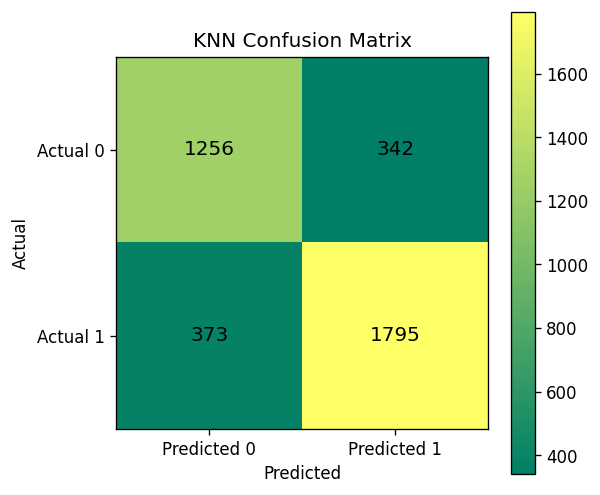

KNN Metrics: {'Accuracy': 0.81, 'Sensitivity (Recall)': 0.786, 'Specificity': 0.828, 'Precision': 0.771, 'F1-Score': 0.778}


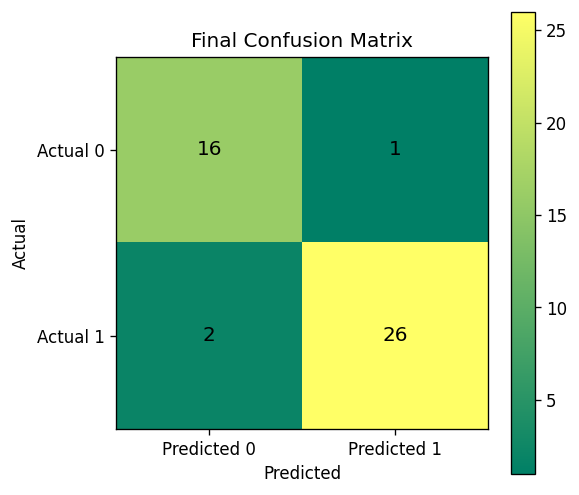

Final Metrics: {'Accuracy': 0.933, 'Sensitivity (Recall)': 0.941, 'Specificity': 0.929, 'Precision': 0.889, 'F1-Score': 0.914}
Accuracy is not improved. Results not saved.


In [90]:
while Last_metrics != {'Accuracy': 0, 'Sensitivity': 0, 'Specificity': 0, 'Precision': 0, 'F1-Score': 0}:
    print(feature_importance_df['Feature'].values)
    print(feature_importance_df['Feature'].values[-1])

    # 獲取要刪除的特徵
    Delete_Feature = feature_importance_df['Feature'].values[-1]
    Delete_Index = Modify_KNN_X.columns.get_loc(Delete_Feature)  # 取得該特徵在列中的位置

    # 刪除特徵列：從 X_train 和 X_test 中刪除該特徵
    Modify_KNN_X_train = np.delete(Modify_KNN_X_train, Delete_Index, axis=1)
    Modify_KNN_X_test = np.delete(Modify_KNN_X_test, Delete_Index, axis=1)

    # 更新 Modify_X（原始資料），刪除該特徵列
    Modify_KNN_X = Modify_KNN_X.drop(Delete_Feature, axis=1)



    # 呼叫訓練和評估 KNN 模型，並傳遞更新後的特徵集
    knn_model, knn_metrics, knn_conf_matrix, knn_y_pred, feature_importance_df = train_knn(Modify_KNN_X_train, Modify_KNN_y_train, Modify_KNN_X_test, Modify_KNN_y_test, Modify_KNN_X.columns)

    # 顯示混淆矩陣
    plot_confusion_matrix(knn_conf_matrix, title='KNN Confusion Matrix')

    # 顯示 KNN 評估指標
    print("KNN Metrics:", knn_metrics)

    # 儲存結果並更新 Last_metrics
    Last_metrics = save_results_to_csv('KNN_Results', info_test, y_test, knn_y_pred, Last_metrics)

In [91]:
info_columns = data[['Name', 'i', 'Bad', 'hands']]
X = data.iloc[:, 5:]  # 特徵列
y = data['label']     # 標籤
#印出x的標題
print(X.columns)

# 分割訓練和測試集
X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(X, y, info_columns, test_size=0.3, random_state=42)

# 特徵標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Index(['systolic peak', 'Diastolic peak', 'Cardiac cycle', 'Cycle Area', 'SSI',
       'Peak to Valley', 'Systolic peak y', 'Delta_T', '1st Derivative cycle',
       '1st Derivative peak', 'Ratio_BA', 'Ratio_CA', 'Ratio_DA',
       'Ratio_BDCE_A', 'Ratio_CDB_A'],
      dtype='object')


Fitting 5 folds for each of 36 candidates, totalling 180 fits
最佳參數: {'class_weight': 'balanced', 'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
特徵重要性排序：
                  Feature  Importance
1         Diastolic peak    0.097754
10              Ratio_BA    0.086334
9    1st Derivative peak    0.086319
3             Cycle Area    0.086313
7                Delta_T    0.075017
14           Ratio_CDB_A    0.073844
13          Ratio_BDCE_A    0.062321
0          systolic peak    0.062124
11              Ratio_CA    0.060146
5         Peak to Valley    0.059410
12              Ratio_DA    0.058562
6        Systolic peak y    0.052973
4                    SSI    0.049283
2          Cardiac cycle    0.046488
8   1st Derivative cycle    0.043112


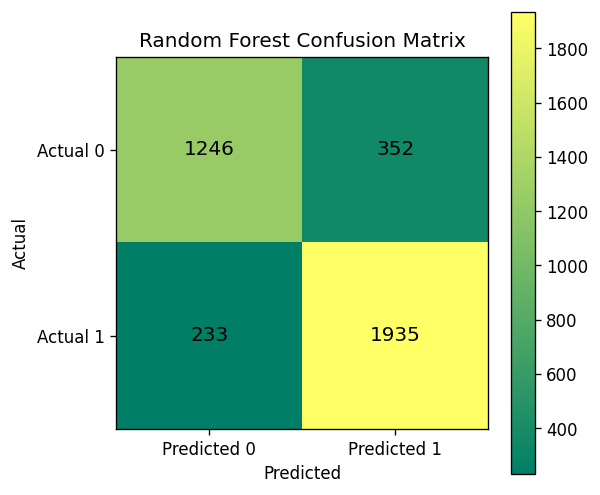

Random Forest Metrics: {'Accuracy': 0.845, 'Sensitivity (Recall)': 0.78, 'Specificity': 0.893, 'Precision': 0.842, 'F1-Score': 0.81}


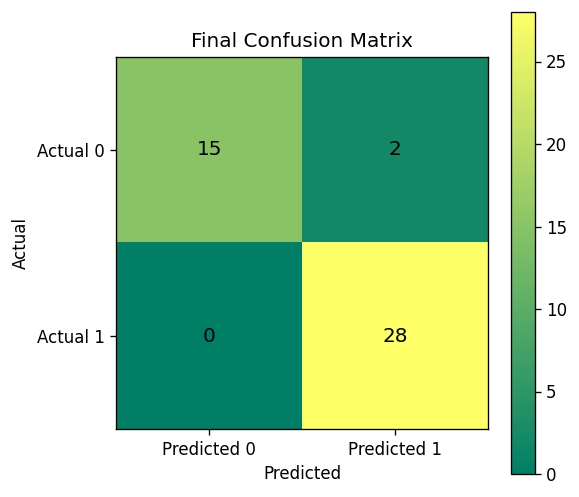

Final Metrics: {'Accuracy': 0.956, 'Sensitivity (Recall)': 0.882, 'Specificity': 1.0, 'Precision': 1.0, 'F1-Score': 0.938}
Results saved to RF_Results.csv
Results saved to RF_Results_Final.csv


In [93]:
def train_rf(X_train, y_train, X_test, y_test, X_columns):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced']
    }

    rf_grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    rf_grid_search.fit(X_train, y_train)

    best_model = rf_grid_search.best_estimator_
    best_params = rf_grid_search.best_params_
    y_pred = best_model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    metrics = calculate_metrics(conf_matrix)

        # 特徵重要性 - Random Forest 原生支援
    feature_importance = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X_columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    print("最佳參數:", best_params)
    print("特徵重要性排序：\n", feature_importance_df)
    
    return best_model, metrics, conf_matrix, y_pred, feature_importance_df

# Random Forest
rf_model, rf_metrics, rf_conf_matrix, rf_y_pred, feature_importance_df = train_rf(X_train, y_train, X_test, y_test, X.columns)
plot_confusion_matrix(rf_conf_matrix, title='Random Forest Confusion Matrix')
print("Random Forest Metrics:", rf_metrics)
Last_metrics = save_results_to_csv('RF_Results', info_test, y_test, rf_y_pred, Last_metrics)


In [94]:
Modify_RF_X = X
Modify_RF_X_train = X_train
Modify_RF_X_test = X_test
Modify_RF_y_train = y_train
Modify_RF_y_test = y_test

['Diastolic peak' 'Ratio_BA' '1st Derivative peak' 'Cycle Area' 'Delta_T'
 'Ratio_CDB_A' 'Ratio_BDCE_A' 'systolic peak' 'Ratio_CA' 'Peak to Valley'
 'Ratio_DA' 'Systolic peak y' 'SSI' 'Cardiac cycle' '1st Derivative cycle']
1st Derivative cycle
Fitting 5 folds for each of 36 candidates, totalling 180 fits
最佳參數: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
特徵重要性排序：
                 Feature  Importance
1        Diastolic peak    0.104886
8   1st Derivative peak    0.093515
9              Ratio_BA    0.091208
3            Cycle Area    0.089055
7               Delta_T    0.076193
13          Ratio_CDB_A    0.073924
0         systolic peak    0.064391
5        Peak to Valley    0.063250
12         Ratio_BDCE_A    0.063173
11             Ratio_DA    0.062974
10             Ratio_CA    0.060561
6       Systolic peak y    0.056000
4                   SSI    0.051856
2         Cardiac cycle    0.049014


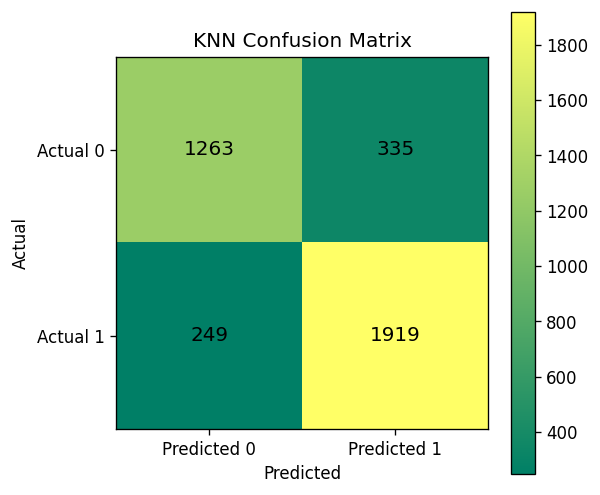

rf Metrics: {'Accuracy': 0.845, 'Sensitivity (Recall)': 0.79, 'Specificity': 0.885, 'Precision': 0.835, 'F1-Score': 0.812}


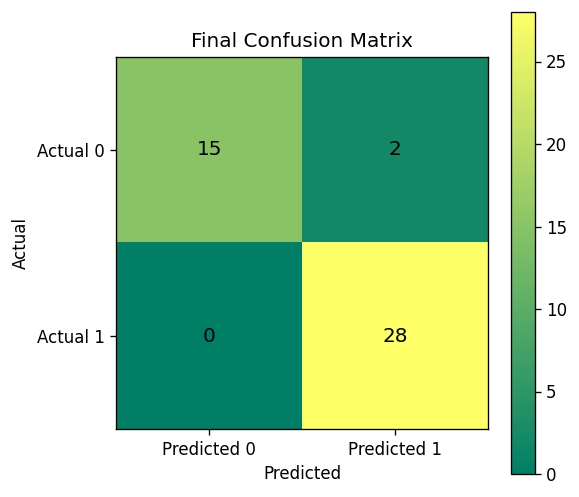

Final Metrics: {'Accuracy': 0.956, 'Sensitivity (Recall)': 0.882, 'Specificity': 1.0, 'Precision': 1.0, 'F1-Score': 0.938}
Accuracy is not improved. Results not saved.


In [95]:
while Last_metrics != {'Accuracy': 0, 'Sensitivity': 0, 'Specificity': 0, 'Precision': 0, 'F1-Score': 0}:
    print(feature_importance_df['Feature'].values)
    print(feature_importance_df['Feature'].values[-1])

    # 獲取要刪除的特徵
    Delete_Feature = feature_importance_df['Feature'].values[-1]
    Delete_Index = Modify_RF_X.columns.get_loc(Delete_Feature)  # 取得該特徵在列中的位置

    # 刪除特徵列：從 X_train 和 X_test 中刪除該特徵
    Modify_RF_X_train = np.delete(Modify_RF_X_train, Delete_Index, axis=1)
    Modify_RF_X_test = np.delete(Modify_RF_X_test, Delete_Index, axis=1)

    # 更新 Modify_X（原始資料），刪除該特徵列
    Modify_RF_X = Modify_RF_X.drop(Delete_Feature, axis=1)



    # 呼叫訓練和評估 KNN 模型，並傳遞更新後的特徵集
    RF_model, RF_metrics, RF_conf_matrix, RF_y_pred, feature_importance_df = train_rf(Modify_RF_X_train, Modify_RF_y_train, Modify_RF_X_test, Modify_RF_y_test, Modify_RF_X.columns)

    # 顯示混淆矩陣
    plot_confusion_matrix(RF_conf_matrix, title='KNN Confusion Matrix')

    # 顯示 KNN 評估指標
    print("rf Metrics:", RF_metrics)

    # 儲存結果並更新 Last_metrics
    Last_metrics = save_results_to_csv('RF_Results', info_test, y_test, RF_y_pred, Last_metrics)